# Dynamic Time Warping
DTW follows a x-step process:
1. Select a window size with which to calculate DTW-distance between slices. In this program,
we select the number of observations _n_ into which the data should be divided, with a
window size of ```step = len(df) / n```. In order to prevent high degrees of dissimilarity
between the remaining data points not included in the window size, the first ```len(df) % step```
points are removed from the dataframe.
2. Calculate the DTW-distance between every pair of slices.
3. Utilize a clustering algorithm (k-means) to

In [1]:
#Import Packages

import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn import preprocessing
from sklearn_extra.cluster import KMedoids
from dtw import *

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
#Load Files

all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

dfs=[]
for path in all_files:
    df = pd.read_csv(path,sep=';', index_col='datetime', parse_dates=True)
    dfs.append(df)
print('Features:')
for col in dfs[1].columns:
    print('\t',col)

col_names = list(dfs[1].columns[0:8])

Features:
	 Accelerometer1RMS
	 Accelerometer2RMS
	 Current
	 Pressure
	 Temperature
	 Thermocouple
	 Voltage
	 Volume Flow RateRMS
	 anomaly
	 changepoint


In [3]:
# Split into n observations

def df_split(df, n):
    step = math.floor(len(df)/n)
    remainder = len(df) % step
    splits = [remainder]
    while max(splits) < len(df):
        splits.append(max(splits) + step)
    splits[-1] = -1
    locs = df.iloc[splits].index
    arrays = []
    for i in range(len(splits) - 1):
        st = locs[i]
        end = locs[i+1]
        arrays.append(df[st:end])
    return arrays, locs


def timewarp(arrays):
    d = np.zeros((len(arrays), len(arrays)))
    for pair in itertools.product(range(len(arrays)), repeat=2):
        template = arrays[pair[0]]
        query = arrays[pair[1]]
        alignment = dtw(query, template, keep_internals=True)
        d[pair[0], pair[1]] = alignment.distance
    return d


..\data\valve1\12.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.027476,0.040633,0.972674,0.058738,68.610787,24.654054,230.242763,30.981714,0.350000,0.003509
std,0.000367,0.001390,0.274368,0.254091,1.274362,0.021407,10.653245,1.665692,0.477179,0.059157
min,0.026445,0.037547,0.372564,-0.929070,65.420200,24.580700,204.222000,28.000000,0.000000,0.000000
25%,0.027219,0.039697,0.737613,0.054711,67.830225,24.644000,224.507750,29.000000,0.000000,0.000000
50%,0.027508,0.040424,0.978509,0.054711,68.722500,24.653600,230.836000,32.000000,0.000000,0.000000
75%,0.027737,0.041349,1.206535,0.054711,69.774275,24.664600,236.145250,32.000000,1.000000,0.000000
max,0.028437,0.047115,1.560930,0.710565,70.485700,24.726400,254.613000,33.000000,1.000000,1.000000


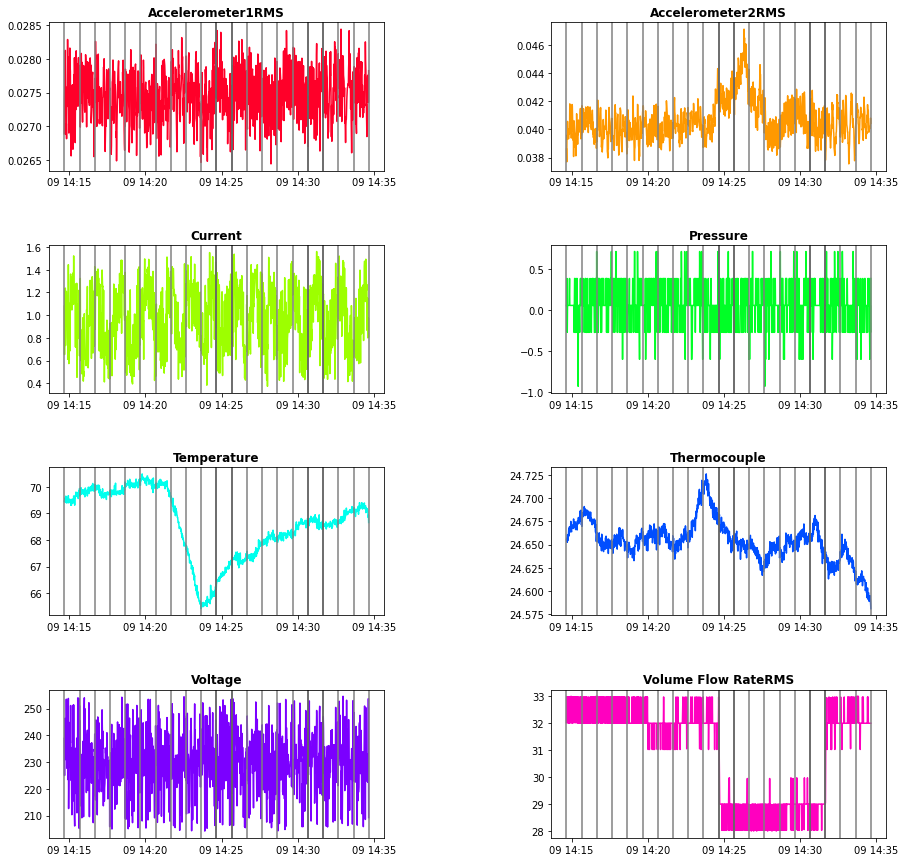

In [4]:
n = 20

# Plot Data
experiments = [19]
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, 8)))
    points = df.index[df['changepoint'] == 1].tolist()
    arrays, locs = df_split(df, n)

    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for loc in locs:
            ax.axvline(loc, color="gray")
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)

In [5]:
#Standardize Data
dfs_stand = []
for df in dfs:
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[col_names])
    dfs_stand.append(pd.DataFrame(data=scaler.transform(df[col_names]), index=df.index, columns=col_names))

In [6]:
from scipy.spatial import distance

# DTW Attempt 1
Ds = []
labels = []
highlights = []
for df in dfs_stand:
    arrays, locs = df_split(df, n)
    d = timewarp(arrays)
    kmedoids = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='heuristic').fit(np.array(d))
    label = kmedoids.labels_
    if sum(label) > 0.5 * len(label):
        label = 1 - np.array(label)
    highlight = [(arrays[i].index[0], arrays[i].index[-1]) for i, x in enumerate(label) if x == 1]
    Ds.append(d)
    labels.append(label)
    highlights.append(highlight)

In [7]:
# DTW Labels to point predictions
for i in range(len(dfs)):
    dfs[i]['prediction'] = 0
    for highlight in highlights[i]:
        dfs[i]['prediction'].loc[highlight[0]:highlight[1]] = 1

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


..\data\valve1\12.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint,prediction
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.027476,0.040633,0.972674,0.058738,68.610787,24.654054,230.242763,30.981714,0.350000,0.003509,0.400877
std,0.000367,0.001390,0.274368,0.254091,1.274362,0.021407,10.653245,1.665692,0.477179,0.059157,0.490291
min,0.026445,0.037547,0.372564,-0.929070,65.420200,24.580700,204.222000,28.000000,0.000000,0.000000,0.000000
25%,0.027219,0.039697,0.737613,0.054711,67.830225,24.644000,224.507750,29.000000,0.000000,0.000000,0.000000
50%,0.027508,0.040424,0.978509,0.054711,68.722500,24.653600,230.836000,32.000000,0.000000,0.000000,0.000000
75%,0.027737,0.041349,1.206535,0.054711,69.774275,24.664600,236.145250,32.000000,1.000000,0.000000,1.000000
max,0.028437,0.047115,1.560930,0.710565,70.485700,24.726400,254.613000,33.000000,1.000000,1.000000,1.000000


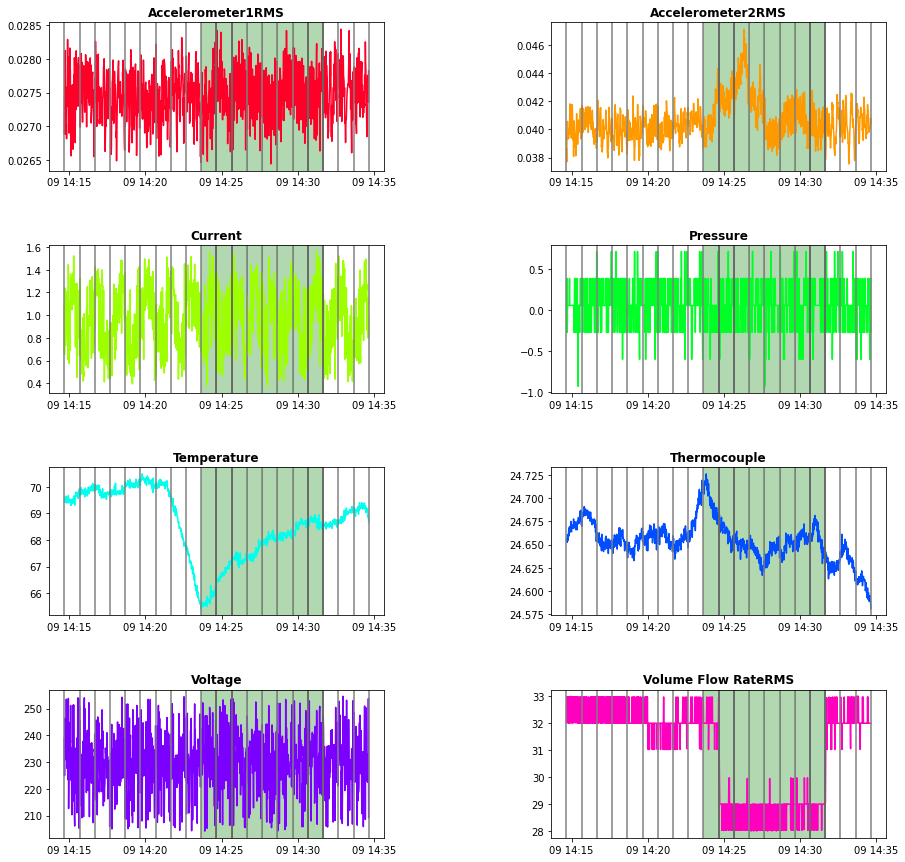

In [8]:
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, 8)))
    points = df.index[df['changepoint'] == 1].tolist()
    preds = highlights[i]
    arrays, locs = df_split(df, n)

    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for loc in locs:
            ax.axvline(loc, color="gray")
        for pred in preds:
            ax.axvspan(pred[0], pred[1], alpha=0.3, color='green')
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)

In [9]:
from utils.evaluating import evaluating_change_point

scores = []
scores_inv = []
for i in range(1, len(dfs)):
    df = dfs[i]
    score = evaluating_change_point(df['anomaly'], df['prediction'], metric='binary')
    score_inv = evaluating_change_point(1 - df['anomaly'], df['prediction'], metric='binary')
    scores.append(score)
    scores_inv.append(score_inv)

False Alarm Rate 1.78 %
Missing Alarm Rate 40.89 %
F1 metric 0.74
False Alarm Rate 59.11 %
Missing Alarm Rate 98.22 %
F1 metric 0.02
False Alarm Rate 67.12 %
Missing Alarm Rate 97.49 %
F1 metric 0.02
False Alarm Rate 2.51 %
Missing Alarm Rate 32.88 %
F1 metric 0.8
False Alarm Rate 67.72 %
Missing Alarm Rate 87.69 %
F1 metric 0.12
False Alarm Rate 12.31 %
Missing Alarm Rate 32.28 %
F1 metric 0.77
False Alarm Rate 23.15 %
Missing Alarm Rate 58.54 %
F1 metric 0.45
False Alarm Rate 41.46 %
Missing Alarm Rate 76.85 %
F1 metric 0.32
False Alarm Rate 23.06 %
Missing Alarm Rate 57.61 %
F1 metric 0.46
False Alarm Rate 42.39 %
Missing Alarm Rate 76.94 %
F1 metric 0.32
False Alarm Rate 23.09 %
Missing Alarm Rate 71.68 %
F1 metric 0.32
False Alarm Rate 28.32 %
Missing Alarm Rate 76.91 %
F1 metric 0.34
False Alarm Rate 30.91 %
Missing Alarm Rate 43.42 %
F1 metric 0.53
False Alarm Rate 56.58 %
Missing Alarm Rate 69.09 %
F1 metric 0.38
False Alarm Rate 23.01 %
Missing Alarm Rate 57.46 %
F1 metric 0.4

In [10]:
weighted_score = sum(np.array(scores) * np.array([len(df) for df in dfs[1:]])) / sum([len(df) for df in dfs[1:]])

print(np.mean(scores))
print(weighted_score)

0.5279411764705881
0.5252927200405777


In [11]:
test = pd.DataFrame(list(zip(scores, scores_inv)), columns=["F1", "F1_swap"])
maxes = test.max(axis=1)
print(np.mean(maxes))
print(test['F1_swap'].mean())

0.6652941176470587
0.2811764705882353


In [12]:
test['Ones'] = [sum(df['anomaly']) for df in dfs[1:]]
test['Zeros'] = [len(df['anomaly']) - sum(df['anomaly']) for df in dfs[1:]]